In [2373]:
from typing import *
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

from scipy.stats import norm

tfd = tfp.distributions

base_dir = "/".join(os.getcwd().split("/")[:-1])

In [2374]:
def naive_monte_carlo_cdf(
        mean: tf.Tensor,
        cov: tf.Tensor,
        lower: tf.Tensor,
        upper: tf.Tensor,
        num_samples: int,
    ):
    
    normal = tfp.distributions.MultivariateNormalFullCovariance(
        loc=mean,
        covariance_matrix=cov,
    )
    
    samples = normal.sample(sample_shape=[num_samples])
    
    upper = tf.tile(upper[None, :], [num_samples, 1])
    lower = tf.tile(lower[None, :], [num_samples, 1])
    
    ge = tf.cast(tf.math.greater_equal(samples, lower), dtype=tf.float32)
    ge = tf.reduce_prod(ge, axis=-1)
    
    le = tf.cast(tf.math.less_equal(samples, upper), dtype=tf.float32)
    le = tf.reduce_prod(le, axis=-1)
    
    indicator = tf.reduce_prod([ge, le], axis=0)
    
    return indicator

In [2375]:
def update_add(
        tensor: tf.Tensor,
        index: List[int],
        update: tf.Tensor,
    ):
    
    index = tf.convert_to_tensor([index])
    update = tf.convert_to_tensor([update])
    
    index = tf.convert_to_tensor(index)
    updated = tf.tensor_scatter_nd_add(
        tensor=tensor,
        indices=index,
        updates=update,
    )
    
    return updated


def vector_dot(
        a: tf.Tensor,
        b: tf.Tensor,
    ):
    
    return tf.reduce_sum(a*b)


@tf.function(jit_compile=True)
def single_sample_cdf(
        mean: tf.Tensor,
        cov_chol: tf.Tensor,
        lower: tf.Tensor,
        upper: tf.Tensor,
        samples: tf.Tensor,
        verbose: bool = False,
    ):
    
    # Identify data type to use for all calculations
    dtype = mean.dtype
    
    # Dimension of the integral
    Q = mean.shape[-1]
    
    # Rename samples, limits and covariance cholesky for brevity
    w = samples
    a = lower
    b = upper
    C = cov_chol
    
    # Initialise transformation variables
    d = tf.zeros_like(mean)
    e = tf.zeros_like(mean)
    f = tf.zeros_like(mean)
    y = tf.zeros_like(mean)
    
    # Initialise standard normal for computing CDFs
    normal = tfp.distributions.Normal(
        loc=tf.zeros(shape=(), dtype=dtype),
        scale=tf.ones(shape=(), dtype=dtype),
    )
    Phi = lambda x: normal.cdf(x)
    iPhi = lambda x: normal.quantile(x)
    
    # Compute transformation variables at the first step
    d = update_add(d, [0], Phi(a[0] / C[0, 0]))
    e = update_add(e, [0], Phi(b[0] / C[0, 0]))
    f = update_add(f, [0], e[0] - d[0])

    for i in tf.range(1, Q):
        
        # Update y[i-1]
        y = update_add(y, [i-1], iPhi(d[i-1] + w[i-1] * (e[i-1] - d[i-1])))
        
        # Update d[i-1] and e[i-1]
        d = update_add(d, [i], Phi((a[i] - vector_dot(C[i, :i], y[:i])) / C[i, i]))
        e = update_add(e, [i], Phi((b[i] - vector_dot(C[i, :i], y[:i])) / C[i, i]))
        f = update_add(f, [i], (e[i] - d[i]) * f[i-1])
        
        # tf.print(y[i-1], d[i], e[i], f[i])
        # input("")
        
    return f[-1]


def mc_mvn_cdf(
        mean: tf.Tensor,
        cov: tf.Tensor,
        lower: tf.Tensor,
        upper: tf.Tensor,
        num_samples: int,
    ):
    
    samples = tfd.MultivariateNormalFullCovariance(
        loc=mean,
        covariance_matrix=cov,
    ).sample(sample_shape=[num_samples])
    
    lt = tf.reduce_all(tf.math.less(lower, samples), axis=1)
    gt = tf.reduce_all(tf.math.less(samples, upper), axis=1)
    
    return tf.cast(tf.math.logical_and(lt, gt), dtype=tf.float32)

In [2376]:
# Set random seed
tf.random.set_seed(0)

# Set default data type
dtype = tf.float64

# Number of samples and dimension of Gaussian
S = 10
Q = 10

# Set up the mean and covariance
mean = tf.zeros(shape=(Q,), dtype=dtype)
rand = tf.random.uniform((Q, Q), dtype=dtype)
cov = 0. * tf.matmul(rand, rand, transpose_b=True) + tf.eye(Q, dtype=dtype)

# Set up lower and upper integration limits
lower = - tf.random.uniform((Q,), dtype=dtype)
upper = tf.random.uniform((Q,), dtype=dtype)

# Draw samples to use within the MC estiamate
samples = tf.random.uniform(shape=(S, Q), dtype=dtype)

# Equally well, you can use Sobol sequences by replacing the line above with
samples = tf.math.sobol_sample(dim=Q, num_results=S, dtype=dtype)

_single_sample_cdf = lambda x: single_sample_cdf(mean, tf.linalg.cholesky(cov), lower, upper, x)
_single_sample_cdf(samples[0])

<tf.Tensor: shape=(), dtype=float64, numpy=1.4911282990024978e-05>

Naive CDF: 0.000015000 +/- 0.000007746
Genz  CDF: 0.000014911 +/- 0.000000000


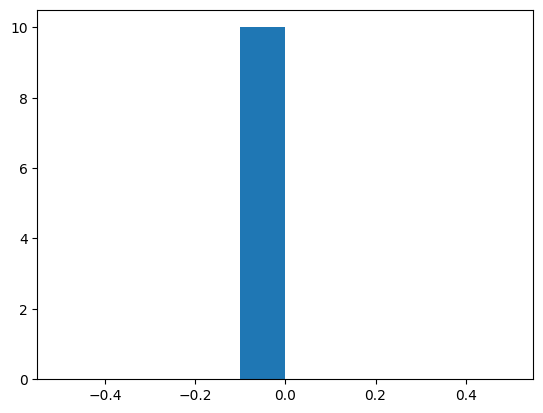

In [2377]:
# Draw samples to use within the MC estiamate
num_samples = 1000000
naive_cdf = mc_mvn_cdf(mean=mean, cov=cov, lower=lower, upper=upper, num_samples=num_samples)

samples = tf.math.sobol_sample(dim=Q, num_results=S, dtype=dtype)
cdf = tf.map_fn(_single_sample_cdf, samples)

print(f"Naive CDF: {tf.reduce_mean(naive_cdf):.9f} +/- {2*tf.math.reduce_std(naive_cdf)/num_samples**0.5:.9f}")
print(f"Genz  CDF: {tf.reduce_mean(cdf):.9f} +/- {2*tf.math.reduce_std(cdf)/S**0.5:.9f}")

plt.hist(cdf)
plt.show()

In [2407]:
from functools import partial

@tf.function
def mvn_cdf(
        mean: tf.Tensor,
        cov: tf.Tensor,
        lower: tf.Tensor,
        upper: tf.Tensor,
        num_sobol: int = 500,
        verbose=False,
    ):
    
    B, Q = mean.shape
    dtype = mean.dtype
    
    chol = tf.linalg.cholesky(cov)
    
    samples = tf.math.sobol_sample(
        dim=Q,
        num_results=num_sobol,
        dtype=dtype,
    )
    
    cdf = lambda args: tf.reduce_mean(tf.map_fn(partial(single_sample_cdf, *args, verbose=verbose), samples))
    cdf = tf.map_fn(cdf, [mean, chol, lower, upper], fn_output_signature=dtype)
    
    return cdf


def compute_bm(
        mean: tf.Tensor,
        threshold: tf.Tensor,
    ):
    """
    Arguments:
        mean: tf.Tensor, shape (B, Q)
        threshold: tf.Tensor, shape (B,)
        
    Returns:
        b: tf.Tensor, shape (B, Q, Q), b[B, K, Q]
        m: tf.Tensor, shape (B, Q, Q), m[B, K, Q]
    """
    
    # Unpack tensor shape and data type
    B, Q = mean.shape
    dtype = mean.dtype
    
    # Compute b tensor
    threshold = tf.tile(threshold[:, None], (1, Q))
    threshold = tf.linalg.diag(threshold) # (B, Q, Q)
    
    b = tf.zeros(shape=(B, Q, Q), dtype=dtype)
    b = b - threshold
    
    # Compute m tensor
    m = mean[:, None, :] - mean[:, :, None]  # (B, Q, Q)
    m = m - tf.linalg.diag(mean)  # (B, Q, Q)
    
    return b, m


def delta(idx: int, dim: int, B: int, transpose: bool, dtype: tf.DType):
    
    o1 = tf.ones(shape=(B, idx, dim), dtype=dtype)
    z1 = tf.zeros(shape=(B, 1, dim), dtype=dtype)
    o2 = tf.ones(shape=(B, dim-idx-1, dim), dtype=dtype)
    
    delta = tf.concat([o1, z1, o2], axis=1)
    delta = tf.transpose(delta, perm=[0, 2, 1]) if transpose else delta
    
    return delta
    

def compute_Sigma(covariance: tf.Tensor):
    
    B, Q, _ = covariance.shape
    dtype = covariance.dtype
    
    Sigma = tf.zeros(shape=(B, Q, Q, Q))
    
    def compute_single_slice(q):
        
        diq = delta(q, Q, B, transpose=False, dtype=dtype)
        dqj = delta(q, Q, B, transpose=True, dtype=dtype)
        
        Sigma_ij = covariance[:, :, :]
        Sigma_iq = covariance[:, :, q:q+1]
        Sigma_qj = covariance[:, q:q+1, :]
        Sigma_qq = covariance[:, q:q+1, q:q+1]
        
        cov = Sigma_ij * diq * dqj - Sigma_iq * diq - Sigma_qj * dqj + Sigma_qq
        
        return cov
    
    Sigma = tf.map_fn(
        compute_single_slice,
        tf.range(Q),
        fn_output_signature=dtype,
    )
    
    Sigma = tf.transpose(Sigma, perm=[1, 0, 2, 3])
        
    return Sigma


def compute_p(
        m_reshaped: tf.Tensor,
        b_reshaped: tf.Tensor,
        Sigma_reshaped: tf.Tensor,
    ):
    
    # Unpack dtype and mean shape
    dtype = m_reshaped.dtype
    BQ, Q = m_reshaped.shape # (B*Q, Q)
    
    # Compute mean, covariance, lower and upper bounds for p mvn normal cdf
    p_cdf_mean = tf.zeros(shape=(BQ, Q), dtype=dtype)  # (B*Q, Q)
    p_cdf_cov = Sigma_reshaped # (B*Q, Q, Q)
    
    p_cdf_upper = b_reshaped - m_reshaped  # (B*Q, Q)
    p_cdf_lower = float("-inf") * tf.ones_like(p_cdf_upper)  # (B*Q, Q)
    
    # Compute MVN CDF
    p = mvn_cdf(
        mean=p_cdf_mean,
        cov=p_cdf_cov,
        lower=p_cdf_lower,
        upper=p_cdf_upper,
    )  # (B*Q,)
    
    p = tf.reshape(p, shape=(B, Q))  # (B, Q)
    
    return p


def compute_ci(
        m_reshaped: tf.Tensor,
        b_reshaped: tf.Tensor,
        Sigma_reshaped: tf.Tensor,
    ):
    """
    Arguments:
        m_reshaped: tf.Tensor, shape (B*Q, Q)
        b_reshaped: tf.Tensor, shape (B*Q, Q)
        Sigma_reshaped: tf.Tensor, shape (B*Q, Q, Q)
    """
    
    # Unpack tensor shape and data type
    BQ, Q = m_reshaped.shape
    dtype = m_reshaped.dtype
    
    # Compute difference between b and m tensors
    diff = b_reshaped - m_reshaped # (B*Q, Q)
    
    # Compute ci, including the ith entry, which we want to remove
    cov_ratio = Sigma_reshaped / tf.linalg.diag_part(Sigma_reshaped)[:, :, None] # (B*Q, Q, Q)
    ci = diff[:, None, :] - diff[:, :, None] * cov_ratio # (B*Q, Q, Q)
    
    # Remove the ith entry by masking ci with a boolean mask with False across
    # the diagonal and True in the off-diagonal terms
    mask = tf.math.logical_not(tf.cast(tf.eye(Q, dtype=tf.int32), dtype=tf.bool))
    mask = tf.tile(mask[None, :, :], (ci.shape[0], 1, 1))
    
    ci = tf.ragged.boolean_mask(ci, mask).to_tensor()
    
    return ci


def compute_Sigmai_matrix(Sigma_reshaped):
    """
    Sigma_reshaped: tf.Tensor, shape (B*Q, Q, Q)
    """
    
    # Unpack tensor shape
    BQ, Q, _ = Sigma_reshaped.shape
    
    Sigma_uv = tf.tile(Sigma_reshaped[:, None, :, :], (1, Q, 1, 1))
    Sigma_iu = tf.tile(Sigma_reshaped[:, :, :, None], (1, 1, 1, Q))
    Sigma_iv = tf.tile(Sigma_reshaped[:, :, None, :], (1, 1, Q, 1))
    Sigma_ii = tf.linalg.diag_part(Sigma_reshaped)[:, :, None, None]
    
    Sigmai_whole = Sigma_uv - Sigma_iu * Sigma_iv / Sigma_ii
    
    def create_blocks(q):
        
        block1 = tf.concat(
            [
                Sigmai_whole[:, q, :q, :q],
                Sigmai_whole[:, q, q+1:, :q],
            ],
            axis=1,
        )
        
        block2 = tf.concat(
            [
                Sigmai_whole[:, q, :q, q+1:],
                Sigmai_whole[:, q, q+1:, q+1:],
            ],
            axis=1,
        )
        
        Sigmai_block = tf.concat([block1, block2], axis=2)
        
        return Sigmai_block
    
    Sigmai = tf.map_fn(
        create_blocks,
        tf.range(Q),
        fn_output_signature=Sigmai_whole.dtype,
    )
    Sigmai = tf.transpose(Sigmai, perm=[1, 0, 2, 3])
    
    return Sigmai


def compute_Phi(
        ci: tf.Tensor,
        Sigmai: tf.Tensor,
    ):
    """
    Arguments:
        ci: tf.Tensor, shape (B*Q, Q, Q-1)
        Sigmai: tf.Tensor, shape (B*Q, Q, Q, Q-1)
    """
    
    # Unpack tensor shape and data type
    BQ, Q, _, _ = Sigmai.shape
    dtype = Sigmai.dtype

    ci_reshaped = tf.reshape(ci, (BQ*Q, Q-1))
    Sigmai_reshaped = tf.reshape(Sigmai, (BQ*Q, Q-1, Q-1))
    
    # Compute mean, covariance, lower and upper bounds for Phi mvn normal cdf
    Phi_cdf_mean = tf.zeros(shape=(BQ*Q, Q-1), dtype=dtype)  # (B*Q*Q, Q)
    Phi_cdf_cov = Sigmai_reshaped  # (B*Q*Q, Q-1, Q-1)
    
    Phi_cdf_upper = ci_reshaped  # (B*Q, Q-1)
    Phi_cdf_lower = float("-inf") * tf.ones_like(Phi_cdf_upper)  # (B*Q*Q, Q-1)
    
    # Compute multivariate cdfs
    mvn_cdfs = mvn_cdf(
        mean=Phi_cdf_mean,
        cov=Phi_cdf_cov,
        lower=Phi_cdf_lower,
        upper=Phi_cdf_upper,
        verbose=True,
    )
    mvn_cdfs = tf.reshape(mvn_cdfs, (B, Q, Q))  # (B, Q, Q)
    
    return mvn_cdfs

In [2408]:
@tf.function
def expected_improvement(
        mean: tf.Tensor,
        covariance: tf.Tensor,
        threshold: tf.Tensor,
        verbose: bool = False,
    ):
    """
    Arguments:
        mean: tf.Tensor, shape (B, Q)
        covariance: tf.Tensor, shape (B, Q, Q)
        threshold: tf.Tensor, shape (B,)
    """
    
    # Unpack dtype and mean shape
    dtype = mean.dtype
    B, Q = mean.shape
    
    # Compute b and m tensors
    b, m = compute_bm(mean=mean, threshold=threshold) # (B, Q, Q), (B, Q, Q)
        
    # Compute Sigma
    Sigma = compute_Sigma(covariance=covariance) # (B, Q, Q, Q)
    
    # Reshape all tensors, for batching
    b_reshaped = tf.reshape(b, (B*Q, Q))
    m_reshaped = tf.reshape(m, (B*Q, Q))
    Sigma_reshaped = tf.reshape(Sigma, (B*Q, Q, Q))
    
    # Compute p tensor
    p = compute_p(
        m_reshaped=m_reshaped,
        b_reshaped=b_reshaped,
        Sigma_reshaped=Sigma_reshaped,
    )
        
    # Compute ci
    ci = compute_ci(
        m_reshaped=m_reshaped,
        b_reshaped=b_reshaped,
        Sigma_reshaped=Sigma_reshaped,
    ) # (B*Q, Q, Q-1)
        
    # Compute Sigma_i
    Sigmai = compute_Sigmai_matrix(
        Sigma_reshaped=Sigma_reshaped,
    ) # (B*Q, Q, Q-1, Q-1)
    
    # Compute Q-1 multivariate CDFs
    Phi_mvn_cdfs = compute_Phi(
        ci=ci,
        Sigmai=Sigmai,
    )
        
    # Compute univariate cdfs
    S_diag = tf.linalg.diag_part(Sigma)
    normal = tfp.distributions.Normal(loc=m, scale=S_diag**0.5)
    uvn_cdfs = tf.math.exp(normal.log_prob(b))  # (B, Q, Q)
    
    Sigma_diag = tf.linalg.diag_part(
        tf.transpose(Sigma, perm=[0, 2, 1, 3])
    )
    Sigma_diag = tf.transpose(Sigma_diag, perm=[0, 2, 1])
    
    T = tf.tile(threshold[:, None], (1, Q))
    
    mean_T_term = (mean - T) * p
    
    sum_term = tf.reduce_sum(
        Sigma_diag * uvn_cdfs * Phi_mvn_cdfs,
        axis=2,
    )
    
    qEI = tf.reduce_sum(mean_T_term + sum_term, axis=1)
    
    return qEI


import numpy as np

def debugging_monte_carlo(
        mean: tf.Tensor,
        covariance: tf.Tensor,
        threshold: tf.Tensor,
        verbose: bool = True,
    ):
    
    mean = mean.numpy()
    cov = covariance.numpy()
    threshold = threshold.numpy()
    
    # Unpack dtype and mean shape
    dtype = mean.dtype
    B, Q = mean.shape
    
    # Compute b
    b = np.zeros(shape=(B, Q, Q), dtype=dtype)
    for n in range(B):
        for k in range(Q):
            for i in range(Q):
                b[n, k, i] = - threshold[n] if k == i else 0.
                
    # Compute m
    m = np.zeros(shape=(B, Q, Q), dtype=dtype)
    for n in range(B):
        for k in range(Q):
            for i in range(Q):
                m[n, k, i] = mean[n, i] - mean[n, k] if k != i else - mean[n, k]
        
    # Compute Sigma
    Sigma = np.zeros(shape=(B, Q, Q, Q), dtype=dtype)
    
    for n in range(B):
        for k in range(Q):
            for i in range(Q):
                for j in range(Q):
                    
                    dik = int(i != k)
                    djk = int(j != k)
                    
                    Sigma[n, k, i, j] = cov[n, i, j] * dik * djk - cov[n, i, k] * dik - cov[n, j, k] * djk + cov[n, k, k]
        
    # Compute p
    p = np.zeros(shape=(B, Q), dtype=dtype)
    
    for n in range(B):
        for k in range(Q):
            
            p_cdf_mean = tf.convert_to_tensor(tf.zeros(shape=(1, Q), dtype=dtype))
            p_cdf_cov = tf.convert_to_tensor(Sigma[n:n+1, k])

            p_cdf_upper = tf.convert_to_tensor(b[n:n+1, k] - m[n:n+1, k])
            p_cdf_lower = tf.convert_to_tensor(float("-inf") * np.ones_like(p_cdf_upper))

            # Compute MVN CDF
            p[n, k] = tf.reduce_mean(
                mc_mvn_cdf(
                    mean=p_cdf_mean[0],
                    cov=p_cdf_cov[0],
                    lower=p_cdf_lower[0],
                    upper=p_cdf_upper[0],
                    num_samples=int(1e7),
                ).numpy()
            )
        
    # Compute c
    c = np.zeros(shape=(B, Q, Q, Q-1), dtype=dtype)
    
    for n in range(B):
        for k in range(Q):
            for i in range(Q):
                for j in range(Q):
                    
                    if i == j:
                        continue
                        
                    else:
                        l = j if j < i else j-1
            
                        c[n, k, i, l] = (b[n, k, j] - m[n, k, j]) - \
                                        (b[n, k, i] - m[n, k, i]) * Sigma[n, k, i, j] / Sigma[n, k, i, i]
        
        
    # Compute Sigmai
    Sigmai = np.zeros(shape=(B, Q, Q, Q-1, Q-1), dtype=dtype)
    
    for n in range(B):
        for k in range(Q):
            for i in range(Q):
                for j in range(Q):
                    for l in range(Q):
                        
                        if i == j or i == l:
                            pass
                        
                        else:
                            u = j if j < i else j-1
                            v = l if l < i else l-1
                            
                            Sigmai[n, k, i, u, v] = Sigma[n, k, j, l] - \
                                                    Sigma[n, k, i, j] * Sigma[n, k, i, l] / Sigma[n, k, i, i]
    
    Phi = np.zeros(shape=(B, Q, Q), dtype=dtype)
    for n in range(B):
        for k in range(Q):
            for i in range(Q):
                Phi[n, k, i] = norm(loc=0., scale=Sigmai[n, k, i, 0, 0]**0.5).cdf(c[n, k, i, 0])
    
    uvn = np.zeros(shape=(B, Q, Q), dtype=dtype)
    for n in range(B):
        for k in range(Q):
            for i in range(Q):
                uvn[n, k, i] = norm(loc=m[n, k, i], scale=Sigma[n, k, i, i]**0.5).cdf(b[n, k, i])
    
    
    qEI = np.zeros(shape=(B,), dtype=dtype)
    for n in range(B):
        for k in range(Q):
            
            qEI[n] = qEI[n] + (mean[n, k] - threshold[n]) * p[n, k]
            
            for i in range(Q):
                qEI[n] = qEI[n] + Sigma[n, k, i, k] * uvn[n, k, i] * Phi[n, k, i]
        
    return list(map(tf.convert_to_tensor, [b, m, Sigma, p, c, Sigmai, Phi, uvn, qEI]))

In [2447]:
tf.random.set_seed(0)

B = 4
Q = 5

# mean = tf.random.uniform(shape=(B, Q), dtype=dtype)
mean = tf.zeros(shape=(B, Q), dtype=dtype)
rand = tf.random.uniform((B, Q, Q), dtype=dtype) / Q**0.5
covariance = 1e-1 * tf.matmul(rand, rand, transpose_b=True) + tf.eye(Q, dtype=dtype)[None, ...]

threshold = tf.random.uniform((B,), dtype=dtype)

expected_improvement(mean=mean, covariance=covariance, threshold=threshold, verbose=False)

# %timeit _ = expected_improvement(mean=mean, covariance=covariance, threshold=threshold)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.76465349, 0.41053497, 1.02134702, 1.06179615])>

In [2449]:
def mcei(
        mean: tf.Tensor,
        covariance: tf.Tensor,
        threshold: tf.Tensor,
        num_samples: int = 1000000,
    ):
    
    covariance = covariance + 1e-6 * tf.eye(covariance.shape[1], dtype=covariance.dtype)
    
    mvn = tfp.distributions.MultivariateNormalFullCovariance(
        loc=mean,
        covariance_matrix=covariance,
    )
    
    samples = mvn.sample(sample_shape=[num_samples])
    
    tiled_threshold = tf.tile(
        threshold[None, :, None],
        (num_samples, 1, 1),
    )
    
    print(f"{samples.shape=} {tiled_threshold.shape=}")
    
    samples_and_thresholds = tf.concat(
        [samples, tiled_threshold], axis=-1
    )
    maxima = tf.reduce_max(samples_and_thresholds, axis=-1)
    improvements = maxima - threshold[None, :]
    
    if tf.reduce_any(tf.less(improvements, tf.zeros_like(improvements))):
        raise Exception
    
    return tf.reduce_mean(improvements, axis=0)

In [2450]:
mcei(mean=mean, covariance=covariance, threshold=threshold)

samples.shape=TensorShape([1000000, 4, 5]) tiled_threshold.shape=TensorShape([1000000, 4, 1])


<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.76701407, 0.41131783, 1.02377429, 1.06344876])>

# TODOs

- Write down qEI derivation following Ginsbourger.
- Implement qEI without batching using for-loops.
- Look at values using above implentation, with special values for mean, covariance and threshold, for debugging purposes.